In [151]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import pickle
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,12)

In [152]:
pd.options.display.max_rows = 30
data1 = pd.read_csv('house.csv')
data1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [153]:
#Initial Report

pr = ProfileReport(data1)
pr.to_file('report_initial.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [154]:
#Based on report, dealing with different variables:

#Dealing with SIZE

#Dropping datapoints with NaN values for Size (only 16)
#Size represents the number of bedrooms. 
    #Split the numeric and string values and keep only numeric values


data1.drop(index=data1[data1['size'].isnull()].index.values, axis = 1, inplace=True)
data1['bed'] = data1['size'].apply(lambda x: x.split(' ')[0])
data1.drop(columns='size', axis=0, inplace=True)
data1.head()

,area_type,availability,location,society,total_sqft,bath,balcony,price,bed
0,Super built-up Area,19-Dec,Electronic City Phase II,Coomee,1056,2.0,1.0,39.07,2
1,Plot Area,Ready To Move,Chikka Tirupathi,Theanmp,2600,5.0,3.0,120.00,4
2,Built-up Area,Ready To Move,Uttarahalli,NaN,1440,2.0,3.0,62.00,3
3,Super built-up Area,Ready To Move,Lingadheeranahalli,Soiewre,1521,3.0,1.0,95.00,3
4,Super built-up Area,Ready To Move,Kothanur,NaN,1200,2.0,1.0,51.00,2


In [155]:
#Type of area and number of balcony does not have any impact on the price of the property. Thus, dropping the features
#5502 nan values for society. Ideal to drop the column
#Approximately 80% of the availability is Ready-to-move. Data irrelavent for model



data1.drop(columns=['area_type', 'balcony'], axis=0, inplace=True)
data1.drop(columns='society', axis=0, inplace=True)
data1.drop(columns='availability', axis=0, inplace=True)

In [156]:
#Locations

#Drop 1 missing datapoint

data1.drop(index=data1[data1['location'].isnull()].index.values, axis=1, inplace=True)
data1['location'] = data1['location'].apply(lambda x: x.strip())    #Strip extra spaces

In [157]:
data1['location'].value_counts()

Whitefield                        540
Sarjapur  Road                    397
Electronic City                   304
Kanakpura Road                    273
Thanisandra                       237
                                 ... 
Vasantapura main road               1
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
Abshot Layout                       1
Name: location, Length: 1293, dtype: int64

In [158]:
location_counts = data1.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_counts

location
Whitefield               540
Sarjapur  Road           397
Electronic City          304
Kanakpura Road           273
Thanisandra              237
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [159]:
lessThanTenProperty = location_counts[location_counts<=10]
lessThanTenProperty

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [160]:
area = lessThanTenProperty.index #Fetching all name of locations which have less than 10 datapoints

In [161]:
data2 = data1.copy()
data2['location'] = data2['location'].apply(lambda x: x if x not in area else 'Rest Of Bangaluru')
data2['location'].value_counts()

Rest Of Bangaluru     2882
Whitefield             540
Sarjapur  Road         397
Electronic City        304
Kanakpura Road         273
                      ... 
Nehru Nagar             11
Banjara Layout          11
LB Shastri Nagar        11
Pattandur Agrahara      11
Narayanapura            11
Name: location, Length: 242, dtype: int64

In [162]:
data3 = data2.copy()

In [163]:
#Total_sqft cannot be categorical

data3['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [164]:
def category_to_float(tofloat):
    try:
        return float(tofloat)
    except:
        r = tofloat.split(' - ')
        if len(r)>1:
            return ((float(r[0])+float(r[1]))/2)
        else:
            return float(re.findall('.*[0-9]',tofloat)[0])
    
        

In [165]:
data3['total_sqft'] = data3['total_sqft'].apply(category_to_float)
data3['total_sqft'].dtype

dtype('float64')

In [166]:
data3['bed'].unique

<bound method Series.unique of 0        2
1        4
2        3
3        3
4        2
        ..
13315    5
13316    4
13317    2
13318    4
13319    1
Name: bed, Length: 13303, dtype: object>

In [167]:
#making sure data type of number of beds is float

data3['bed'] = data3['bed'].apply(category_to_float)

In [168]:
data3[(data3['total_sqft']/data3['bed'])<300]

,location,total_sqft,bath,price,bed
9,Rest Of Bangaluru,1020.0,6.0,370.0,6.0
45,HSR Layout,600.0,9.0,200.0,8.0
58,Murugeshpalya,1407.0,4.0,150.0,6.0
68,Devarachikkanahalli,1350.0,7.0,85.0,8.0
70,Rest Of Bangaluru,500.0,3.0,100.0,3.0
...,...,...,...,...,...
13277,Rest Of Bangaluru,1400.0,7.0,218.0,7.0
13279,Rest Of Bangaluru,1200.0,5.0,130.0,6.0
13281,Margondanahalli,1375.0,5.0,125.0,5.0
13303,Vidyaranyapura,774.0,5.0,70.0,5.0


In [169]:
data4 = data3.copy()
data4.drop(index=data3[(data3['total_sqft']/data3['bed'])<300].index, axis = 'index', inplace=True)


In [170]:
data5 = data4.copy()
data5['ppsqft'] = data5['price']*100000/data5['total_sqft']
data5.head()

,location,total_sqft,bath,price,bed,ppsqft
0,Electronic City Phase II,1056.0,2.0,39.07,2.0,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4.0,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3.0,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3.0,6245.890861
4,Kothanur,1200.0,2.0,51.00,2.0,4250.000000


In [171]:
location_group = data5.groupby('location')
location_group.describe()

total_sqft                            ...        ppsqft                            
                               count         mean          std  ...           50%           75%           max
location                                                        ...                                          
1st Block Jayanagar             10.0  1915.000000   667.549416  ...  12258.569501  15018.022329  18750.000000
1st Phase JP Nagar              23.0  1800.695652   800.365169  ...   8425.613866   9901.259524  25000.000000
2nd Phase Judicial Layout       11.0  1173.272727   341.193227  ...   3500.000000   4739.316239   5000.000000
2nd Stage Nagarbhavi             9.0  2127.777778  1013.382674  ...  15033.333333  18750.000000  20416.666667
5th Block Hbr Layout             7.0  2112.571429  1589.967175  ...   5259.146341   5697.081982  17083.333333
...                              ...          ...          ...  ...           ...           ...           ...
Yelachenahalli                  17.0  1321.294118   375.409903  ...   5454.545455   7172.131148  13333.333333
Yelahanka                      207.0  1783.630435  2964.755264  ...   5021.520803   5863.536471  19875.776398
Yelahanka New Town              38.0  1215.526316   762.328252  ...   5040.025016   5413.853463  22475.000000
Yelenahalli                     13.0  1268.461538   190.068240  ...   3835.625000   4121.212121   5176.876618
Yeshwanthpur                    80.0  1454.343750   616.906316  ...   5524.437781   7319.161262  17647.058824

[242 rows x 40 columns]

(array([ 47.,  84.,  95., 127.,  74.,  37.,  20.,   7.,   8.,  13.,   6.,
          6.,   2.,   3.,   2.,   2.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 2592.59259259,  3500.63378887,  4408.67498515,  5316.71618142,
         6224.7573777 ,  7132.79857398,  8040.83977025,  8948.88096653,
         9856.9221628 , 10764.96335908, 11673.00455536, 12581.04575163,
        13489.08694791, 14397.12814419, 15305.16934046, 16213.21053674,
        17121.25173302, 18029.29292929, 18937.33412557, 19845.37532185,
        20753.41651812, 21661.4577144 , 22569.49891068, 23477.54010695,
        24385.58130323, 25293.6224995 , 26201.66369578, 27109.70489206,
        28017.74608833, 28925.78728461, 29833.82848089, 30741.86967716,
        31649.91087344, 32557.95206972, 33465.99326599, 34374.03446227,
        35

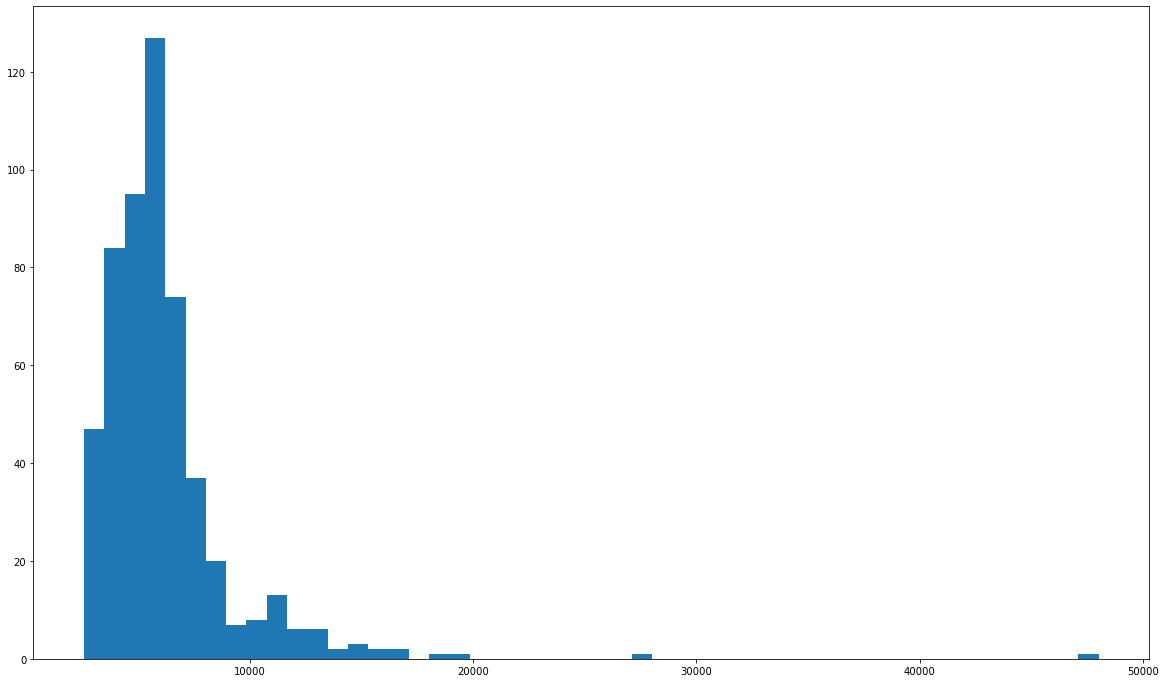

In [172]:
#Displaying price per sq ft based on top 3 densed (based on data) locations


plt.hist(x=location_group.get_group(location_counts.index[0])['ppsqft'],bins=50)

(array([ 2.,  5.,  5., 10., 18., 18., 20., 34., 15., 16., 22., 36., 25.,
        16., 20., 12., 13., 11., 17., 15., 10., 14.,  1.,  6.,  7.,  1.,
         1.,  3.,  2.,  0.,  2.,  3.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         1.,  1.,  0.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  2.]),
 array([ 2551.02040816,  2817.46031746,  3083.90022676,  3350.34013605,
         3616.78004535,  3883.21995465,  4149.65986395,  4416.09977324,
         4682.53968254,  4948.97959184,  5215.41950113,  5481.85941043,
         5748.29931973,  6014.73922902,  6281.17913832,  6547.61904762,
         6814.05895692,  7080.49886621,  7346.93877551,  7613.37868481,
         7879.8185941 ,  8146.2585034 ,  8412.6984127 ,  8679.138322  ,
         8945.57823129,  9212.01814059,  9478.45804989,  9744.89795918,
        10011.33786848, 10277.77777778, 10544.21768707, 10810.65759637,
        11077.09750567, 11343.53741497, 11609.97732426, 11876.41723356,
        12142.85714286, 12409.29705215, 12675.73696145, 12942.176870

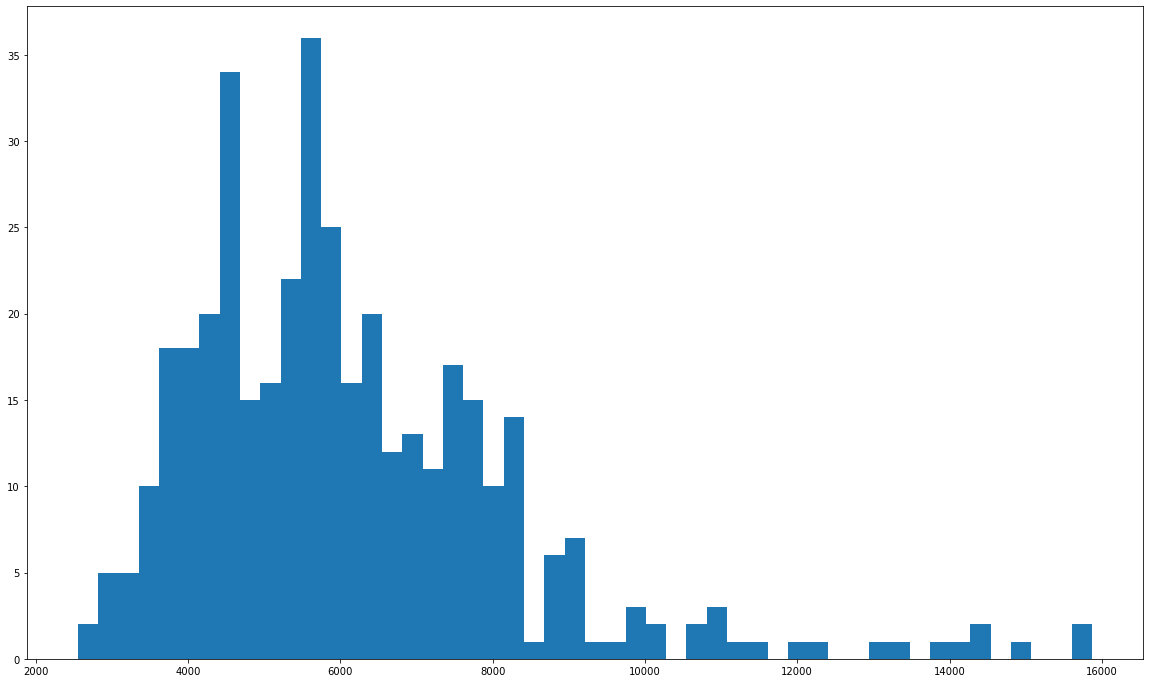

In [173]:
plt.hist(x=location_group.get_group(location_counts.index[1])['ppsqft'],bins=50)

(array([10., 65., 41., 39., 64., 49., 13.,  7.,  1.,  0.,  1.,  3.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1666.66666667,  2411.11111111,  3155.55555556,  3900.        ,
         4644.44444444,  5388.88888889,  6133.33333333,  6877.77777778,
         7622.22222222,  8366.66666667,  9111.11111111,  9855.55555556,
        10600.        , 11344.44444444, 12088.88888889, 12833.33333333,
        13577.77777778, 14322.22222222, 15066.66666667, 15811.11111111,
        16555.55555556, 17300.        , 18044.44444444, 18788.88888889,
        19533.33333333, 20277.77777778, 21022.22222222, 21766.66666667,
        22511.11111111, 23255.55555556, 24000.        , 24744.44444444,
        25488.88888889, 26233.33333333, 26977.77777778, 27722.22222222,
        28466.66666667, 29211.11111111, 29955.55555556, 30700.      

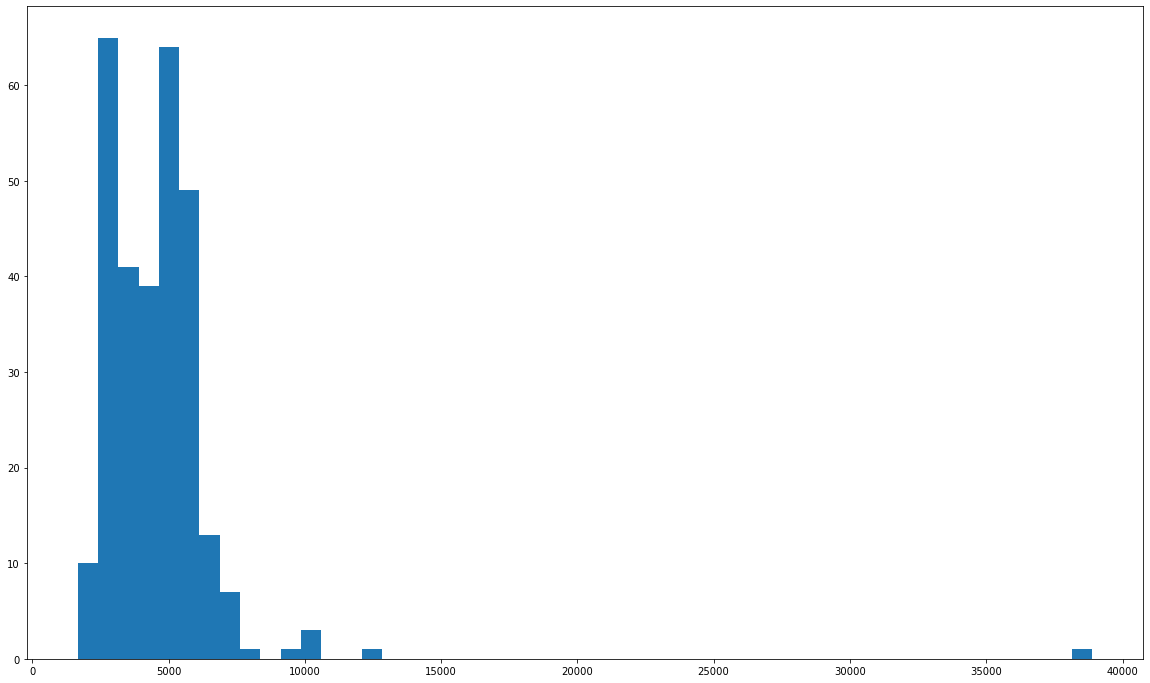

In [174]:
plt.hist(x=location_group.get_group(location_counts.index[2])['ppsqft'],bins=50)

In [175]:
#Removing outliers based on location.

data6 = pd.DataFrame()
for loc, df in data5.groupby('location'):
    low = np.mean(df['ppsqft']) - np.std(df['ppsqft'])
    high = np.mean(df['ppsqft']) + np.std(df['ppsqft'])
    inter = df[(df['ppsqft']>low) & (df['ppsqft']<high)]
    data6 = pd.concat([data6,inter], ignore_index=True)


data6.shape

(10293, 6)

In [176]:
def area_price(loc,b1,b2):
    a2 = data6[(data6['location']==loc) & (data6['bed']==b1)]
    a3 = data6[(data6['location']==loc) & (data6['bed']==b2)]
    plt.scatter(x=a2['total_sqft'], y= a2['ppsqft'], marker='+', color = 'b', label=b1,s=50)
    plt.scatter(x=a3['total_sqft'], y= a3['ppsqft'], color = 'g',label=b2,s=50)
    plt.legend()
    plt.title(loc)

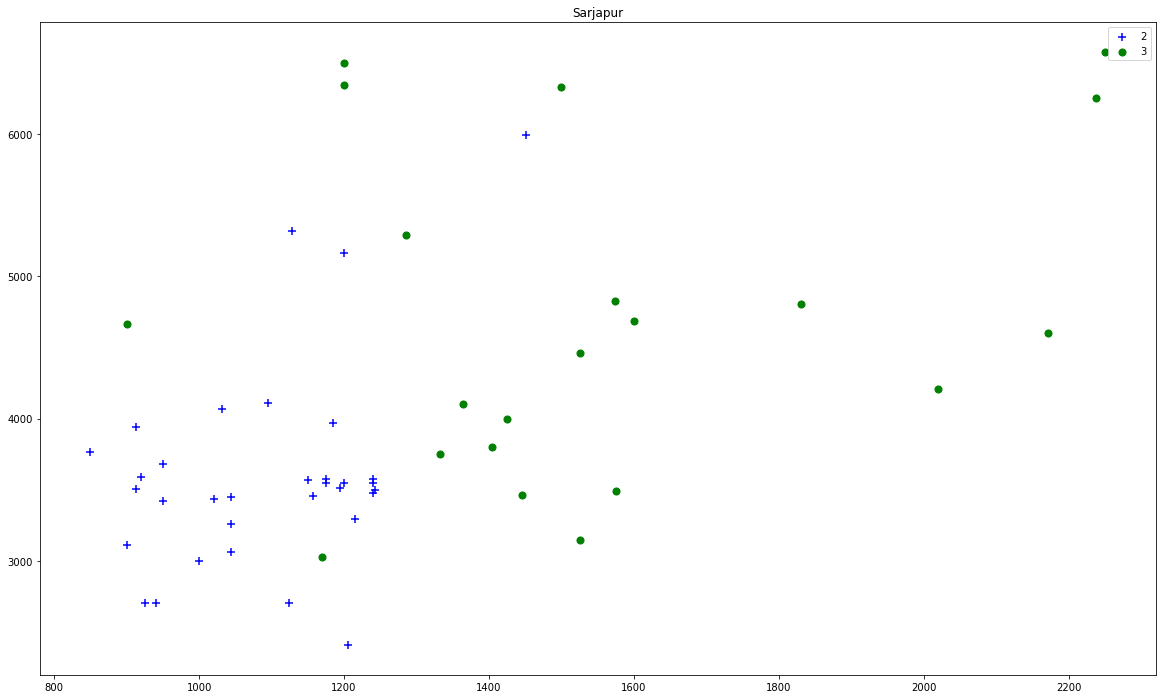

In [177]:
area_price('Sarjapur',2,3)

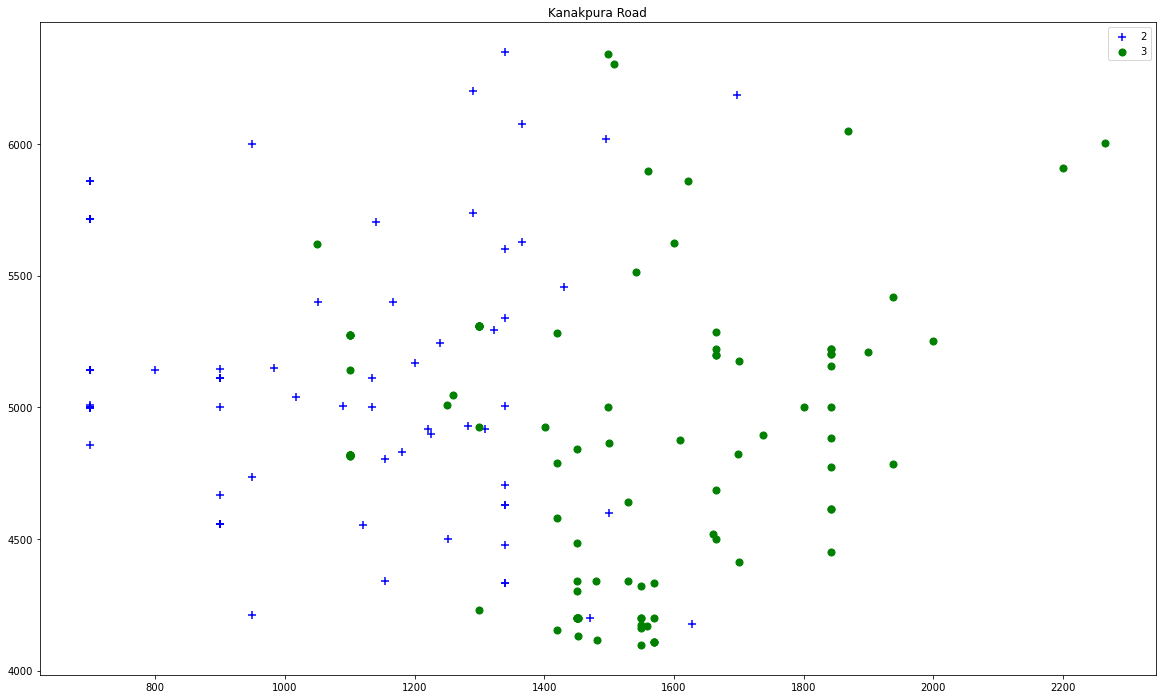

In [178]:
area_price(location_counts.index[3],2,3)

In [180]:
report = ProfileReport(data6)
report.to_file('report_final.html')

,location,total_sqft,bath,price,bed,ppsqft
293,Abbigere,3000.0,8.0,150.0,8.0,5000.000000
523,Arekere,4125.0,9.0,265.0,9.0,6424.242424
1301,Bommanahalli,3000.0,8.0,140.0,8.0,4666.666667
1640,Chikkabanavar,4000.0,7.0,110.0,8.0,2750.000000
3043,Hennur Road,5000.0,8.0,250.0,8.0,5000.000000
...,...,...,...,...,...,...
7624,Rest Of Bangaluru,3300.0,9.0,450.0,10.0,13636.363636
7654,Rest Of Bangaluru,5425.0,13.0,275.0,13.0,5069.124424
7689,Rest Of Bangaluru,3200.0,8.0,130.0,9.0,4062.500000
7918,Rest Of Bangaluru,3300.0,8.0,310.0,8.0,9393.939394


# One hot encoding on locations

In [181]:
onehot = pd.get_dummies(data6['location'])
onehot.drop(columns='Rest Of Bangaluru', axis='columns', inplace=True)
onehot.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,Budigere,CV Raman Nagar,Chamrajpet,Chandapura,Channasandra,...,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Parappana Agrahara,Pattandur Agrahara,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [182]:
finaldf = pd.concat([data6,onehot],axis='columns')
finaldf.head()

,location,total_sqft,bath,price,bed,ppsqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,...,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Parappana Agrahara,Pattandur Agrahara,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4.0,15017.543860,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3.0,11901.840491,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3.0,12533.333333,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3.0,10833.333333,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2.0,11983.805668,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [183]:
finaldf.drop(columns=['ppsqft'],axis=1,inplace=True) #dropping price per sqft
finaldf.dropna(axis=0,inplace=True)
finaldf.head()

,location,total_sqft,bath,price,bed,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,...,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Parappana Agrahara,Pattandur Agrahara,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [184]:
x = finaldf.drop(columns=['location','price'],axis=1)
y = finaldf['price']

In [185]:
def find_best_model(x,y,how):
    if how == 'scaled':
        scale = StandardScaler()
        x = scale.fit_transform(x)
    models ={
        'Linear Regression':{
            'model': LinearRegression(),
            'prams': {}
        },
        'Ridge':{
            'model': Ridge(),
            'prams':{
                'alpha': [1,2]
            }
        },
        'Lasso':{
            'model': Lasso(),
            'prams':{
                'selection': ['cyclic', 'random'],
                'alpha': [1,2]
            }
        },
        'DTR':{
            'model': DecisionTreeRegressor(),
            'prams':{
                'criterion': ['squared_error', 'friedman_mse', 'poisson'],
                'splitter': ['best', 'random']
            }
        }
    }
    scores=[]
    bestscore = 0
    for i in range(4,10):
        for model, config in models.items():
            grid_sreach = GridSearchCV(config['model'], config['prams'], cv=i)
            grid_sreach.fit(x,y)
            scores.append({
                'Model': config['model'],
                'Best Score': grid_sreach.best_score_,
                'Best Parameters': grid_sreach.best_params_,
                'CV': i
            })
    return (pd.DataFrame(scores,columns=['Model','Best Score','Best Parameters','CV']))

In [186]:
best_scaled = find_best_model(x,y,'scaled')
best_unscaled = find_best_model(x,y,'unscaled')

In [187]:
best_scaled

,Model,Best Score,Best Parameters,CV
0,LinearRegression(),-6.347267e+27,{},4
1,Ridge(),6.735195e-01,{'alpha': 1},4
2,Lasso(),6.717790e-01,"{'alpha': 1, 'selection': 'random'}",4
3,DecisionTreeRegressor(),5.742083e-01,"{'criterion': 'friedman_mse', 'splitter': 'ran...",4
4,LinearRegression(),-1.017942e+28,{},5
5,Ridge(),6.771278e-01,{'alpha': 1},5
6,Lasso(),6.777445e-01,"{'alpha': 1, 'selection': 'cyclic'}",5
7,DecisionTreeRegressor(),5.163143e-01,"{'criterion': 'squared_error', 'splitter': 'ra...",5
8,LinearRegression(),-3.587604e+28,{},6
9,Ridge(),7.181312e-01,{'alpha': 2},6


In [188]:
best_unscaled

,Model,Best Score,Best Parameters,CV
0,LinearRegression(),-2.398832e+16,{},4
1,Ridge(),6.740550e-01,{'alpha': 2},4
2,Lasso(),6.722410e-01,"{'alpha': 1, 'selection': 'random'}",4
3,DecisionTreeRegressor(),5.326458e-01,"{'criterion': 'squared_error', 'splitter': 'ra...",4
4,LinearRegression(),6.771282e-01,{},5
5,Ridge(),6.773199e-01,{'alpha': 2},5
6,Lasso(),6.742273e-01,"{'alpha': 2, 'selection': 'random'}",5
7,DecisionTreeRegressor(),4.971930e-01,"{'criterion': 'squared_error', 'splitter': 'ra...",5
8,LinearRegression(),-2.996125e+16,{},6
9,Ridge(),7.216017e-01,{'alpha': 1},6


Best achived accuracy is 

Let's give one more try

In [189]:
better = 0
for i in range(150):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.236)
    x_train_scaled= StandardScaler().fit_transform(x_train)
    x_test_scaled = StandardScaler().fit_transform(x_test)
    linear = LinearRegression()
    linear.fit(x_train_scaled,y_train)
    score = linear.score(x_test_scaled, y_test)
    if score>better:
        better = score
        print(score)
        with open('model_pkl','wb') as f:
            pickle.dump(linear,f)
            

0.7421927297340802
0.7714498020929597
0.8092268959051663
0.823030155715291
0.8277855929749689
0.8378085814959442
0.8434676437426921
0.8439437662497336
0.8461745279923418
0.8596287624268162


So, our best Linear model stored have 86% accuracy

In [190]:
# Calculating mean and standard deviation to normalize input data
area_mean = np.mean(x.total_sqft)
area_std = np.std(x.total_sqft)

bath_mean = np.mean(x.bath)
bath_std = np.std(x.bath)

bed_mean = np.mean(x.bed)
bed_std = np.std(x.bed)

In [191]:
def predict_price(location,area,bed,bath):
    loc_col = np.where(x.columns==location)[0][0]
    
    p = np.zeros(len(x.columns))
    p[0] = (area - area_mean)/area_std
    p[1] = (bath - bath_mean)/bath_std
    p[2] = (bed - bed_mean)/bed_std
    if loc_col>1:
        p[loc_col]=1
    
    with open('model_pkl','rb') as f:
        m = pickle.load(f)
    
    return round(m.predict([p])[0],2)*100000

In [192]:
print(predict_price('Vishveshwarya Layout', 1200, 3, 2), 'INR') 

6057000.0 INR


In [193]:
finaldf.tail()

,location,total_sqft,bath,price,bed,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,...,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Parappana Agrahara,Pattandur Agrahara,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
10288,Yeshwanthpur,1676.0,3.0,92.13,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10289,Yeshwanthpur,2503.0,3.0,138.00,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10290,Yeshwanthpur,1855.0,3.0,135.00,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10291,Yeshwanthpur,1876.0,3.0,160.00,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10292,Yeshwanthpur,1675.0,3.0,92.13,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [194]:
print(predict_price('Yeshwanthpur',1675,3,3), 'INR')

10507000.0 INR


Original Price is 9213000 while the predicted is 10392000 a difference of approx 1200000, 12.5%

In [195]:
#converting columns to json file for final deployment in Flask

import json
columns ={
    'column': [col.lower() for col in x.columns]
}
other_data = {
    'size': [area_mean,area_std],
    'bed': [bed_mean,bed_std],
    'bath': [bath_mean,bath_std]
}
with open('columns.json','w') as f:
    f.write(json.dumps(columns))
with open('other.json','w') as f:
    f.write(json.dumps(other_data))